In [ ]:
import sys
import torch
sys.path.append('../src')

import numpy as np
from generator import *
from evaluation import *
from fair_model import FairModel
from baselines import LR, CvxFairModel, EOFairModel
from utils import gen_plot_data, plot_axes, combine_tuples,combine_tuples_active_only

In [2]:
from simulator import *

In [3]:
# Build Bank model
bank = Bank()
agent_train = Agent(n_samples=4000, protect_ratio=0.5, eps=0.5, base=[0.2, 1.0], seed=2026)
agent_test = Agent(n_samples=1000, protect_ratio=0.5, eps=0.5, base=[0.2, 1.0], seed=2027)


In [4]:
steps = 5

s_train, adj, edges, Xs_train, Ys_train, Ds_train, Ps, Os, Us, As_train = run_simulation(
    decision_model=bank,
    repayment_model=bank,
    agent=agent_train,
    steps=steps,
    enforce_demographic_mixing=True,
    k_same=8,
    k_other=2,
    directed=False,
    graph_seed=2026,
    seed=2026,
    decision_coef=0.8,
    repayment_coef=0.8,
 )

s_test, adj, edges, Xs_test, Ys_test, Ds_test, Ps, Os, Us, As_test = run_simulation(
    decision_model=bank,
    repayment_model=bank,
    agent=agent_test,
    steps=steps,
    enforce_demographic_mixing=True,
    k_same=8,
    k_other=2,
    directed=False,
    graph_seed=2026,
    seed=2026,
    decision_coef=0.8,
    repayment_coef=0.8,
 )
s_comb, X_comb, Y_comb = combine_tuples_active_only(s_train, Xs_train, Ys_train,As_train)

In [ ]:

# import numpy as np
# # out_path = "../src/simulation_results_neighbors.csv"
# # save_agent_panel_csv(
# #     out_path,
# #     s=s,
# #     Xs=Xs,
# #     adj=adj,
# #     Ds=Ds,
# #     Ys=Ys,
# #     Ps=Ps,
# #     Us=Us,
# #     As=As,
# #     Os=Os,
# #     t0=0,
# #     neighbor_k=10,
# #  )

# # print("Wrote:", out_path)

# try:
#     import pandas as pd
#     # Build the combined data frame as before
#     data = np.hstack([s_comb.reshape(-1, 1), X_comb, Y_comb.reshape(-1, 1)])
#     base_columns = ["s"] + [f"x{i}" for i in range(X_comb.shape[1])] + ["y"]
#     df = pd.DataFrame(data, columns=base_columns)

#     # Infer per-step sizes from the original lists (Xs_train/Ys_train)
#     # Each Xs_train[t] is (n_t, d); we accumulate to compute global row indices per step.
#     step_sizes = [len(x_step) for x_step in Xs_train]
#     cum = np.cumsum([0] + step_sizes)  # boundaries

#     # Create arrays for (step, i-in-step)
#     idx = np.arange(len(df))
#     # Find step for each global index using cumulative boundaries
#     step = np.searchsorted(cum[1:], idx, side="right")
#     i_in_step = idx - cum[step]

#     df.insert(0, "step", step)
#     df.insert(1, "i", i_in_step)
#     df.insert(2, "comb_idx", idx)

#     # Show first 10 rows with mapping columns
#     print(df.head(10).to_string(index=False))
# except Exception as e:
#     print("Failed to annotate with step/index due to:", e)
#     # Fallback to the simple 10-row preview
#     try:
#         import pandas as pd
#         data = np.hstack([s_comb.reshape(-1, 1), X_comb, Y_comb.reshape(-1, 1)])
#         columns = ["s"] + [f"x{i}" for i in range(X_comb.shape[1])] + ["y"]
#         df_preview = pd.DataFrame(data, columns=columns)
#         print(df_preview.head(10).to_string(index=False))
#     except Exception as e2:
#         print("pandas not available (", e2, ") — showing raw arrays instead:\n")
#         print("s:\n", s_comb[:10])
#         print("\nX:\n", X_comb[:10])
#         print("\ny:\n", Y_comb[:10])

In [ ]:
# # Print s, x0, x1, y for steps 0..5 at i=1 and i=2
# import numpy as np

# # Derive per-step sizes and cumulative boundaries from Xs_train
# step_sizes = [len(x_step) for x_step in Xs_train]
# cum = np.cumsum([0] + step_sizes)

# steps_to_show = [0, 1, 2, 3, 4, 5]
# indices_to_show = [1, 2]

# rows = []
# for t in steps_to_show:
#     if t < 0 or t >= len(step_sizes):
#         rows.append((t, None, None, None, None, None, "step out of range"))
#         continue
#     for i in indices_to_show:
#         if i < 0 or i >= step_sizes[t]:
#             rows.append((t, i, None, None, None, None, "i out of range for this step"))
#             continue
#         gi = cum[t] + i  # global index in combined arrays
#         s_val = float(s_comb[gi])
#         x0 = float(X_comb[gi, 0])
#         x1 = float(X_comb[gi, 1])
#         y_val = float(Y_comb[gi])
#         rows.append((t, i, s_val, x0, x1, y_val, ""))

# try:
#     import pandas as pd
#     out_df = pd.DataFrame(rows, columns=["step", "i", "s", "x0", "x1", "y", "note"])
#     print(out_df.to_string(index=False))
# except Exception:
#     for r in rows:
#         print(r)

### Baseline: LR

In [ ]:
lr = LR(l2_reg=1e-5)
lr.train(s_comb, X_comb, Y_comb)

steps = 5

# run_simulation returns: s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As
s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As = run_simulation(
    decision_model=lr,
    repayment_model=bank,
    agent=agent_test,
    steps=steps,
    enforce_demographic_mixing=True,
    k_same=8,
    k_other=2,
    directed=False,
    graph_seed=2026,
    seed=2026,
    decision_coef=0.8,
    repayment_coef=0.8,
 )

compute_statistics(s, Xs, Ds, lr, OYs=Ys,As=As)

### Baseline: FMDP

In [5]:
d = X_comb.shape[1]            # number of X columns
cfm = CvxFairModel(n_features=d + 1, l2_reg=1e-5, tao=1.565)  # s + X

# cfm = CvxFairModel(n_features=len(Xs_train[0][0])+2, l2_reg=1e-5, tao=1.565)

cfm.train(s_comb, X_comb, Y_comb)

s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As = run_simulation(
    decision_model=cfm,
    repayment_model=bank,
    agent=agent_test,
    steps=steps,
    enforce_demographic_mixing=True,
    k_same=8,
    k_other=2,
    directed=False,
    graph_seed=2026,
    seed=2026,
    decision_coef=0.8,
    repayment_coef=0.8,
 )

compute_statistics(s_test, Xs, Ds, cfm, OYs=Ys,As=As) 

------------------------------ Step 1 - Fair Model with Demographic Parity ------------------------------
Acc: 68.3%
Retention: 100.0%
Short Fairness: 0.170
Long fairness: 0.262
------------------------------ Step 2 - Fair Model with Demographic Parity ------------------------------
Acc: 70.1%
Retention: 78.4%
Short Fairness: 0.180
Long fairness: 0.288
------------------------------ Step 3 - Fair Model with Demographic Parity ------------------------------
Acc: 69.6%
Retention: 50.5%
Short Fairness: 0.182
Long fairness: 0.307
------------------------------ Step 4 - Fair Model with Demographic Parity ------------------------------
Acc: 68.8%
Retention: 38.6%
Short Fairness: 0.178
Long fairness: 0.523
------------------------------ Step 5 - Fair Model with Demographic Parity ------------------------------
Acc: 69.4%
Retention: 28.7%
Short Fairness: 0.170
Long fairness: 0.733




/Users/jh22215/anaconda3/envs/cmdp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Baseline: FMEO

In [6]:
eqm = EOFairModel(n_features=len(Xs_train[0][0])+2, l2_reg=1e-5, tao=1.5)
eqm.train(s_comb, X_comb, Y_comb)

s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As = run_simulation(
    decision_model=eqm,
    repayment_model=bank,
    agent=agent_test,
    steps=steps,
    enforce_demographic_mixing=True,
    k_same=8,
    k_other=2,
    directed=False,
    graph_seed=2026,
    seed=2026,
    decision_coef=0.8,
    repayment_coef=0.8,
 )

compute_statistics(s_test, Xs, Ds, eqm, OYs=Ys,As=As) 

optimal
------------------------------ Step 1 - Fair Model with Equal Oppertunity ------------------------------
Acc: 70.1%
Retention: 100.0%
Short Fairness: 0.052
Long fairness: 0.102
------------------------------ Step 2 - Fair Model with Equal Oppertunity ------------------------------
Acc: 72.3%
Retention: 76.3%
Short Fairness: 0.042
Long fairness: 0.154
------------------------------ Step 3 - Fair Model with Equal Oppertunity ------------------------------
Acc: 72.0%
Retention: 50.7%
Short Fairness: 0.044
Long fairness: 0.155
------------------------------ Step 4 - Fair Model with Equal Oppertunity ------------------------------
Acc: 70.6%
Retention: 37.9%
Short Fairness: 0.046
Long fairness: 0.159
------------------------------ Step 5 - Fair Model with Equal Oppertunity ------------------------------
Acc: 71.6%
Retention: 29.7%
Short Fairness: 0.042
Long fairness: 0.155




/Users/jh22215/anaconda3/envs/cmdp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jh22215/anaconda3/envs/cmdp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

### FM

In [ ]:
fm = FairModel(n_features=len(Xs_train[0][0])+1, lr=5e-3, l2_reg=1e-5, sf_reg=0.119, lf_reg=0.154)
fm.train(s_train, Xs_train, Ys_train, Xs_train, Ys_train, epochs=1000, plot=True)

num_iters = 50

theta_true = fm.params
theta_list     = [np.copy(theta_true)]
theta_gaps     = []


# inital theta
theta = np.copy(theta_true)

for t in range(num_iters):
    # adjust distribution to current theta
    s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As = run_simulation(
    decision_model=fm,
    repayment_model=bank,
    agent=agent_train,
    steps=steps,
    enforce_demographic_mixing=True,
    k_same=8,
    k_other=2,
    directed=False,
    graph_seed=2026,
    seed=2026,
    decision_coef=0.8,
    repayment_coef=0.8,
 ) 
    # learn on induced distribution
    fm.train(s_train, Xs_train, Ys_train, Xs, Ys, epochs=10, plot=False)
    D_last = np.asarray(Ds[-1]).astype(int)   # decisions at t*
    A_last = np.asarray(As[-1]).astype(int)   # active/applying at t*
    approval_all = D_last.mean()
    retention = A_last.mean()
    approval_active = D_last[A_last == 1].mean() if (A_last == 1).any() else float("nan")

    # keep track of statistic
    theta_new = fm.params
    gap = np.linalg.norm(theta_new - theta)
    theta_gaps.append(gap)
    theta_list.append(np.copy(theta_new))

    theta = np.copy(theta_new)

[RRM 0] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.514 | ||Δθ||=1.2578e-02
[RRM 1] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.516 | ||Δθ||=7.0803e-03
[RRM 2] retention_t*=0.328 | approve_all=-0.503 | approve_active=0.514 | ||Δθ||=1.3486e-02
[RRM 3] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.518 | ||Δθ||=5.5281e-04
[RRM 4] retention_t*=0.329 | approve_all=-0.500 | approve_active=0.518 | ||Δθ||=6.8715e-04
[RRM 5] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.518 | ||Δθ||=6.6353e-04
[RRM 6] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.518 | ||Δθ||=6.9511e-04
[RRM 7] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.518 | ||Δθ||=6.2915e-04
[RRM 8] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.518 | ||Δθ||=4.7332e-04
[RRM 9] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.517 | ||Δθ||=6.4436e-04
[RRM 10] retention_t*=0.329 | approve_all=-0.501 | approve_active=0.517 | ||Δθ||=6.6874e-0

In [8]:
s, adj, edges, Xs, Ys, Ds, Ps, Os, Us, As = run_simulation(
    decision_model=fm,
    repayment_model=bank,
    agent=agent_test,
    steps=steps,
    enforce_demographic_mixing=True,
    k_same=8,
    k_other=2,
    directed=False,
    graph_seed=2026,
    seed=2026,
    decision_coef=0.8,
    repayment_coef=0.8,
 )

compute_statistics(s_test, Xs, Ds, fm, OYs=Ys,As=As) 

------------------------------ Step 1 - Long-term Fair Model ------------------------------
Acc: 68.9%
Retention: 100.0%
Short Fairness: 0.132
Long fairness: 0.074
------------------------------ Step 2 - Long-term Fair Model ------------------------------
Acc: 69.7%
Retention: 79.7%
Short Fairness: 0.130
Long fairness: 0.102
------------------------------ Step 3 - Long-term Fair Model ------------------------------
Acc: 68.9%
Retention: 55.9%
Short Fairness: 0.130
Long fairness: 0.117
------------------------------ Step 4 - Long-term Fair Model ------------------------------
Acc: 67.3%
Retention: 43.1%
Short Fairness: 0.136
Long fairness: 0.248
------------------------------ Step 5 - Long-term Fair Model ------------------------------
Acc: 68.0%
Retention: 32.7%
Short Fairness: 0.134
Long fairness: 0.382




/Users/jh22215/anaconda3/envs/cmdp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Save trained parameters to disk (portable: NumPy .npz)
from pathlib import Path
import numpy as np
import torch

ckpt_dir = Path("checkpoints")
ckpt_dir.mkdir(parents=True, exist_ok=True)

params_path = ckpt_dir / "fairmodel_params.npz"
state_path  = ckpt_dir / "fairmodel_state_dict.pt"

theta = np.asarray(fm.params, dtype=np.float32)  # shape: (n_features + 1,)

np.savez(
    params_path,
    params=theta,
    n_features=int(fm.linear.weight.shape[1]),
)

# Optional: save full torch state_dict too (lets you restore optimizer, etc. if you want later)
torch.save(fm.state_dict(), state_path)

print(f"Saved params to: {params_path.resolve()}")
print(f"Saved state_dict to: {state_path.resolve()}")
print("theta shape:", theta.shape)

In [ ]:
# Load parameters somewhere else and apply to a fresh FairModel
# (Works even in a different notebook/script, as long as you have the same n_features)
from pathlib import Path
import numpy as np
import torch


def load_params_npz(npz_path):
    npz_path = Path(npz_path)
    data = np.load(npz_path)
    return np.asarray(data["params"], dtype=np.float32)


def apply_theta_to_fairmodel(model: FairModel, theta: np.ndarray) -> None:
    """theta is [w0, w1, ..., w_{d-1}, b] matching FairModel.params."""
    theta = np.asarray(theta, dtype=np.float32).ravel()
    d = int(model.linear.weight.shape[1])
    if theta.shape[0] != d + 1:
        raise ValueError(f"theta has len {theta.shape[0]} but expected {d + 1} (d={d})")

    w = torch.from_numpy(theta[:d]).view(1, d)
    b = torch.tensor([float(theta[-1])], dtype=w.dtype)

    with torch.no_grad():
        model.linear.weight.copy_(w)
        model.linear.bias.copy_(b)

    # keep old_* in sync with the loaded weights
    model.save_params()


params_path = Path("checkpoints") / "fairmodel_params.npz"
loaded_theta = load_params_npz(params_path)

# Example: create a new model with the same n_features and load the theta
fm_loaded = FairModel(
    n_features=int(fm.linear.weight.shape[1]),
    lr=5e-3,
    l2_reg=1e-5,
    sf_reg=0.119,
    lf_reg=0.154,
)
apply_theta_to_fairmodel(fm_loaded, loaded_theta)

print("Loaded theta OK. First 5 entries:", loaded_theta[:5])
print("Params match:", np.allclose(fm_loaded.params, loaded_theta))

## Comparison of All Methods

Metrics computed for: ['LR', 'FMDP', 'FMEO', 'FMLT']


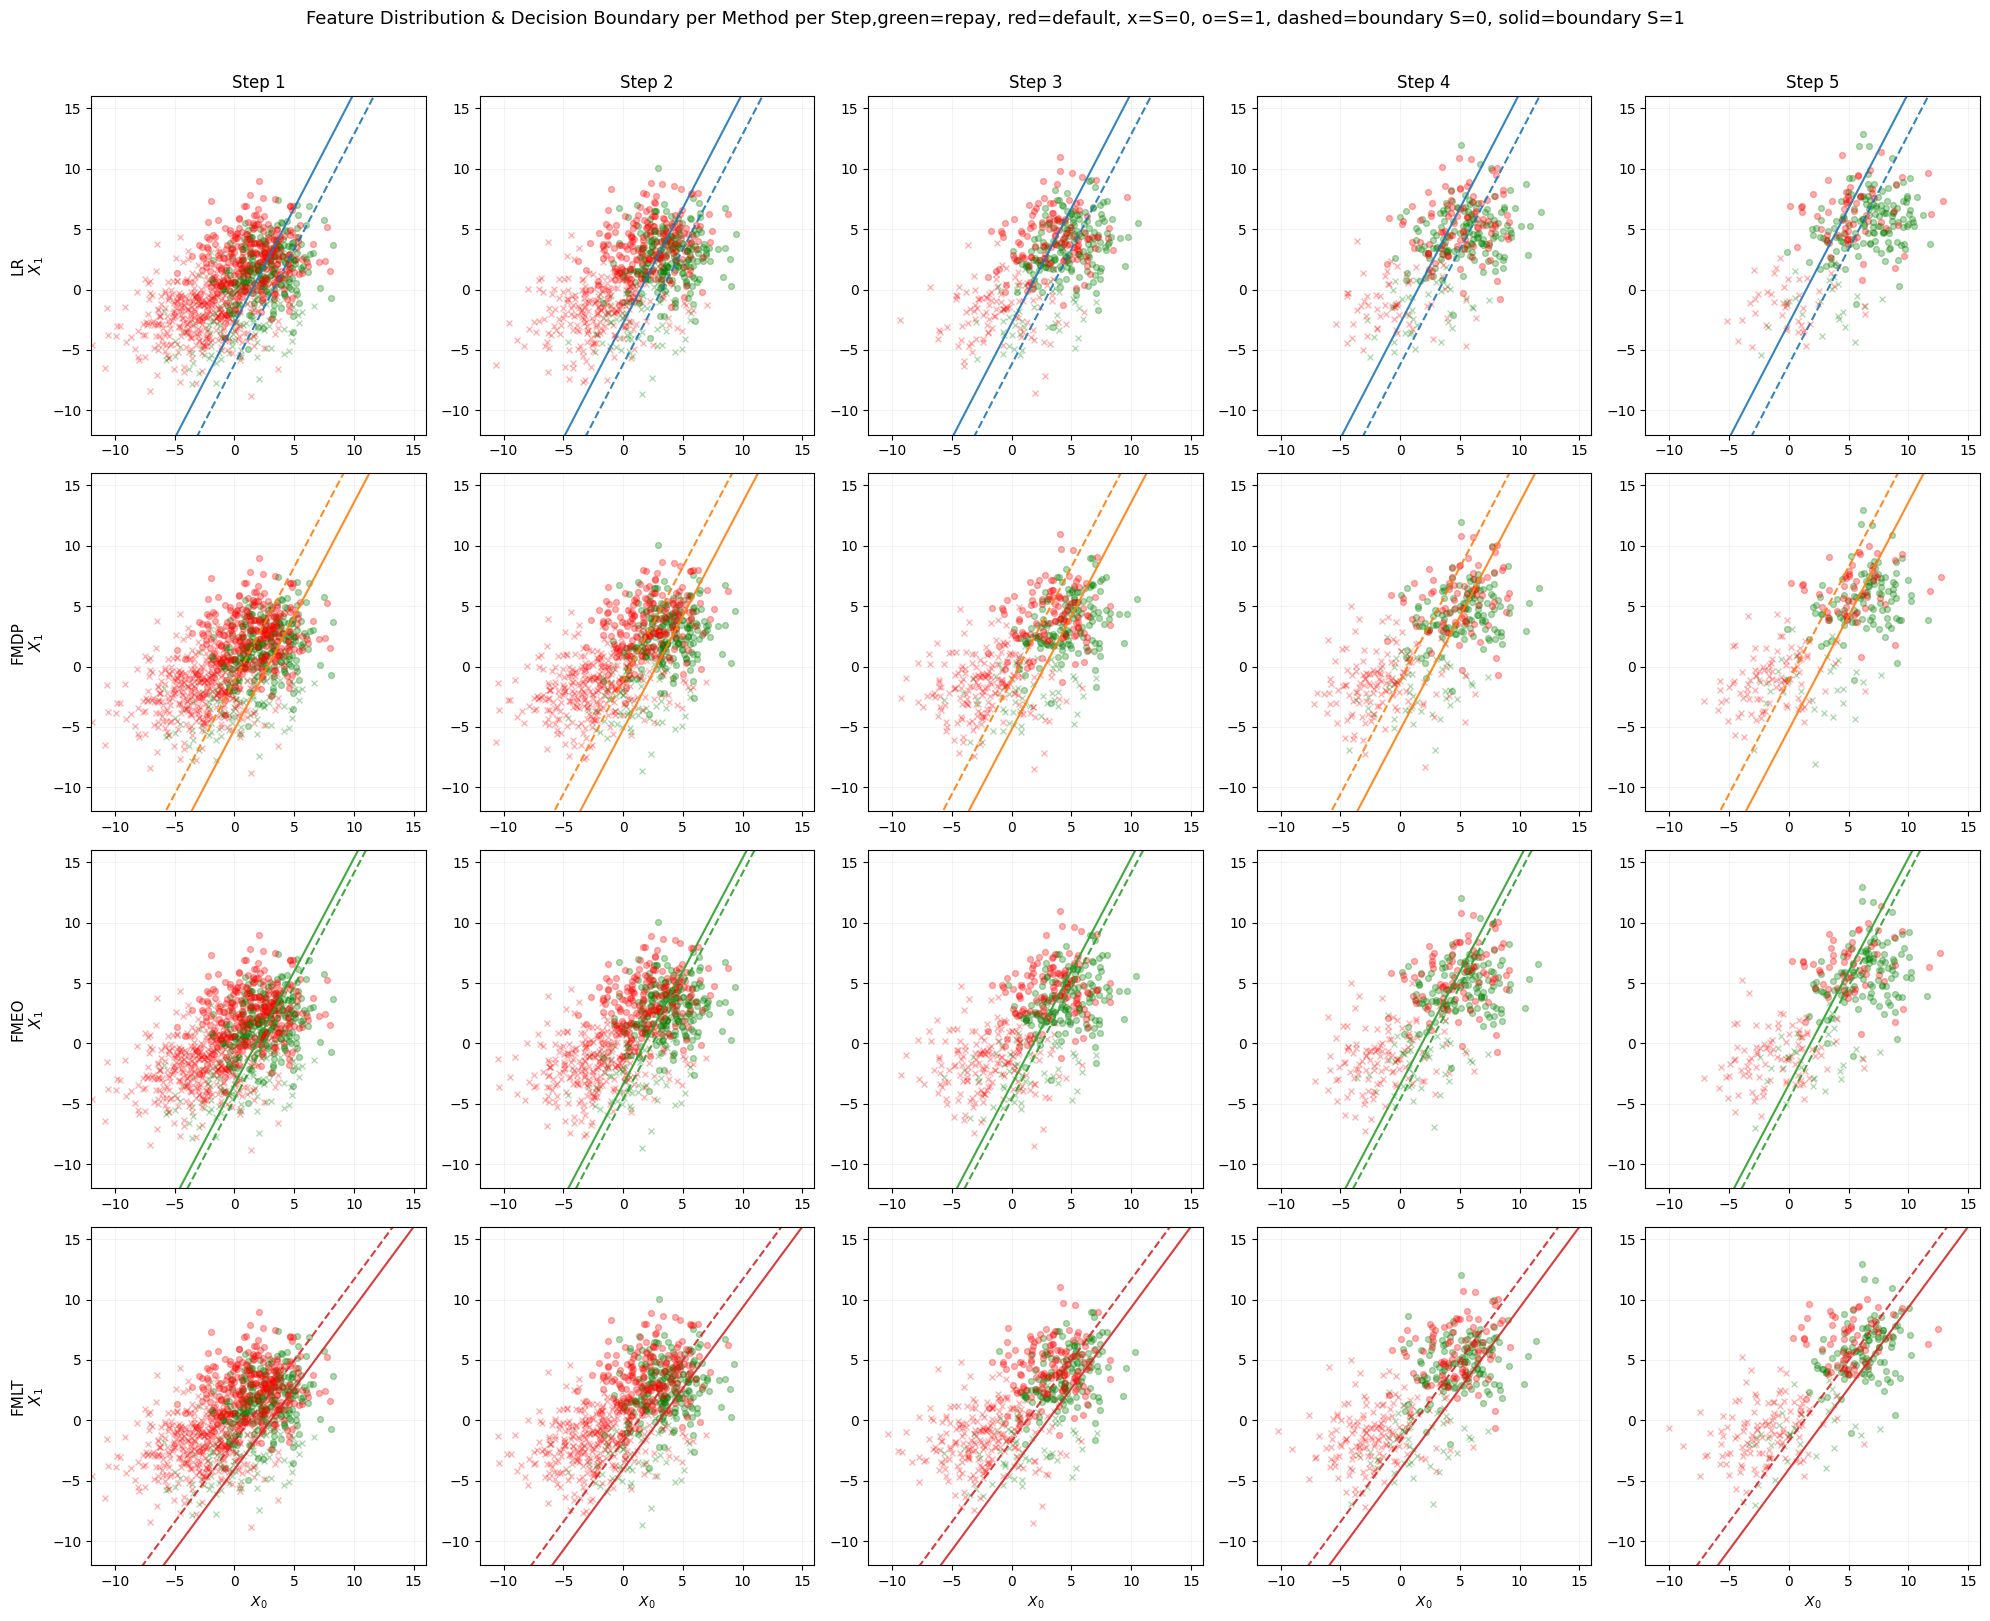

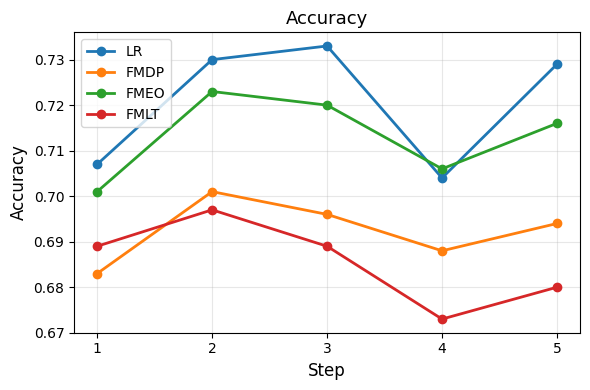

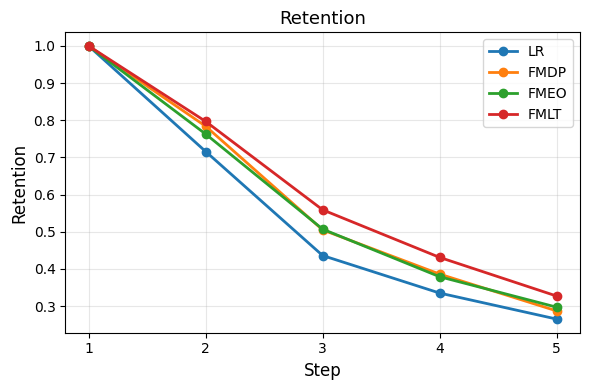

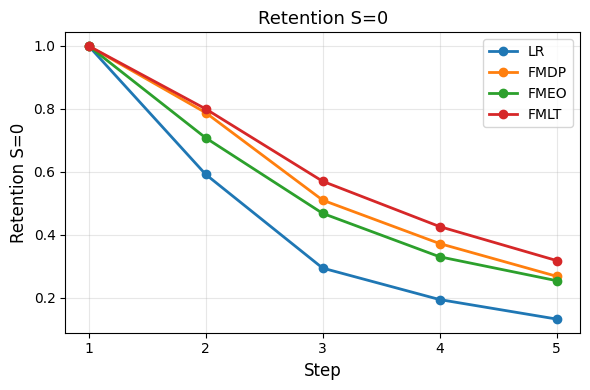

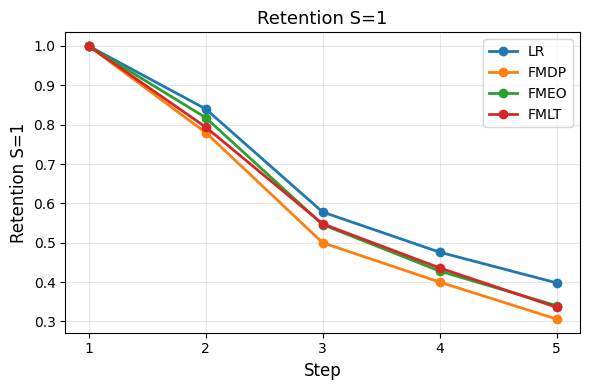

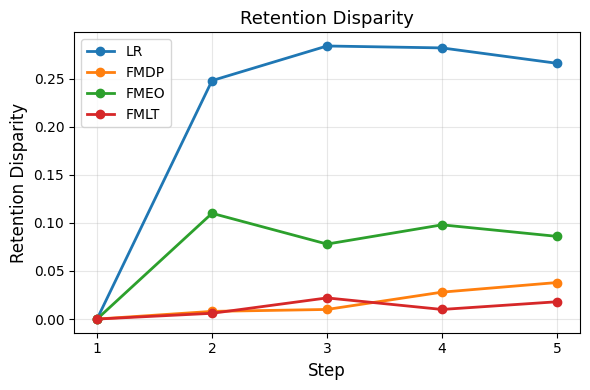

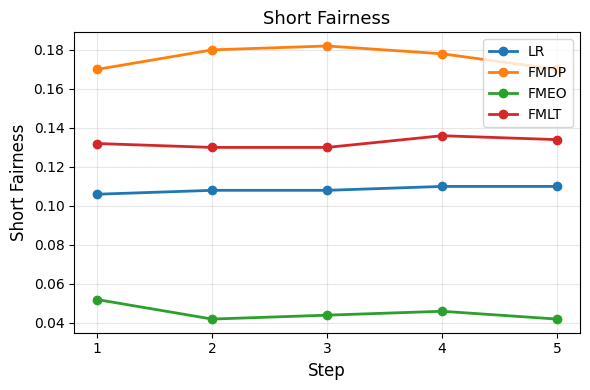

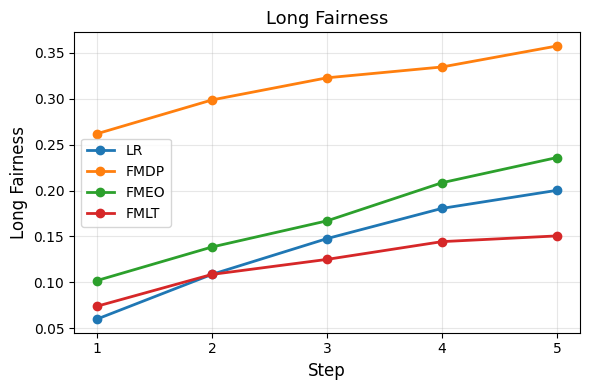

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ── 1. Run simulations for all 4 models (models must already be trained) ──
sim_kwargs = dict(
    repayment_model=bank, agent=agent_test, steps=5,
    enforce_demographic_mixing=True, k_same=8, k_other=2,
    directed=False, graph_seed=2026, seed=2026,
    decision_coef=0.8, repayment_coef=0.8,
)

models = [
    ("LR", lr),
    ("FMDP", cfm),
    ("FMEO", eqm),
    ("FMLT", fm),
]
colors = {
    "LR": "tab:blue",
    "FMDP": "tab:orange",
    "FMEO": "tab:green",
    "FMLT": "tab:red",
}

results = {}
for name, model in models:
    s_sim, adj_sim, edges_sim, Xs_sim, Ys_sim, Ds_sim, Ps_sim, Os_sim, Us_sim, As_sim = \
        run_simulation(decision_model=model, **sim_kwargs)
    results[name] = {
        "model": model, "s": s_sim, "Xs": Xs_sim, "Ys": Ys_sim,
        "Ds": Ds_sim, "As": As_sim,
    }

# ── 2. Compute metrics for each model ──
T = 5
step_arr = np.arange(1, T + 1)

metrics = {}
for name, res in results.items():
    s_eval = s_test
    model = res["model"]
    Xs, Ys, Ds, As = res["Xs"], res["Ys"], res["Ds"], res["As"]
    s_e = np.asarray(s_eval).astype(int)

    accs, s_fairs, l_fairs = [], [], []
    retention = compute_retention_rate(Xs, As)
    ret_disp = compute_retention_disparity(s_e, As)

    d0 = max(1, int((s_e == 0).sum()))
    d1 = max(1, int((s_e == 1).sum()))
    ret0, ret1 = np.ones(T), np.ones(T)
    for t in range(T):
        A_t = np.asarray(As[t]).astype(int)
        ret0[t] = (A_t[s_e == 0] == 1).sum() / d0
        ret1[t] = (A_t[s_e == 1] == 1).sum() / d1

    for i in range(T):
        accs.append(compute_accuracy(s_e, Xs[i], Ys[i], model))
        s_fairs.append(abs(compute_short_cond_fairness(s_e, Xs[i], model)))
        if i == 0:
            l_fairs.append(abs(compute_post_long_cond_fairness(s_e, Xs[:i+1], model)))
        else:
            prob = compute_post_long_cond_probs(s_e, Xs[:i+1], Ys[:i+1])
            l_fairs.append(abs(compute_post_long_cond_fairness(s_e, Xs[:i+1], model, prob)))

    metrics[name] = {
        "acc": np.array(accs), "retention": retention,
        "ret0": ret0, "ret1": ret1,
        "s_fair": np.array(s_fairs), "l_fair": np.array(l_fairs),
        "ret_disp": ret_disp,
    }

print("Metrics computed for:", list(metrics.keys()))

# ── 3. Decision boundary helper ──
def get_boundary(model, x_range=(-10, 15)):
    params = model.params
    if params is None or abs(params[2]) < 1e-12:
        return None
    x = np.linspace(*x_range, 200)
    y0 = (-params[-1] - params[0] * 0 - params[1] * x) / params[2]
    y1 = (-params[-1] - params[0] * 1 - params[1] * x) / params[2]
    return x, y0, y1

# ── 4. X0 vs X1: grid of (methods x steps), each with its OWN data ──
method_names = [name for name, _ in models]
n_methods = len(method_names)

fig, axes = plt.subplots(n_methods, T, figsize=(4 * T, 4 * n_methods))
for row, name in enumerate(method_names):
    res = results[name]
    model = res["model"]
    s_e = np.asarray(s_test).astype(int)
    bnd = get_boundary(model)

    for t in range(T):
        ax = axes[row, t]
        X_t = np.asarray(res["Xs"][t])
        Y_t = np.asarray(res["Ys"][t]).astype(int)
        A_t = np.asarray(res["As"][t]).astype(int)

        # Scatter: each method's own feature distribution
        for g, marker in [(0, 'x'), (1, 'o')]:
            for lbl, c in [(1, 'green'), (0, 'red')]:
                m = (s_e == g) & (Y_t == lbl) & (A_t == 1)
                if m.sum() == 0:
                    continue
                fc = 'none' if g == 1 else c
                ax.scatter(X_t[m, 0], X_t[m, 1], c=c, marker=marker,
                           facecolors=fc, s=18, alpha=0.3, linewidths=1)

        # Decision boundary
        if bnd is not None:
            bx, by0, by1 = bnd
            ax.plot(bx, by0, '--', color=colors[name], linewidth=1.5, alpha=0.9)
            ax.plot(bx, by1, '-', color=colors[name], linewidth=1.5, alpha=0.9)

        ax.set_xlim(-12, 16)
        ax.set_ylim(-12, 16)
        if row == 0:
            ax.set_title(f'Step {t+1}', fontsize=12)
        if t == 0:
            ax.set_ylabel(f'{name}\n$X_1$', fontsize=11)
        if row == n_methods - 1:
            ax.set_xlabel('$X_0$', fontsize=10)
        ax.grid(True, alpha=0.15)

fig.suptitle('Feature Distribution & Decision Boundary per Method per Step,'
             'green=repay, red=default, x=S=0, o=S=1, dashed=boundary S=0, solid=boundary S=1',
             fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# ── 5. Metric comparison plots: one figure per metric ──
metric_defs = [
    ("Accuracy",             "acc"),
    ("Retention",            "retention"),
    ("Retention S=0",        "ret0"),
    ("Retention S=1",        "ret1"),
    ("Retention Disparity",  "ret_disp"),
    ("Short Fairness",       "s_fair"),
    ("Long Fairness",        "l_fair"),
]

for title, key in metric_defs:
    fig, ax = plt.subplots(figsize=(6, 4))
    for name in metrics:
        vals = metrics[name][key]
        ax.plot(step_arr, vals, 'o-', color=colors[name], label=name, linewidth=2, markersize=6)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.set_xticks(step_arr)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()